# General import functions

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import scanpy as sc
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv
import anndata

sc.logging.print_versions()

scanpy==1.4.5.dev115+g52e25b5 anndata==0.6.22.post2.dev68+g92b6791 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [ ]:
pwd

# Load the data

In [ ]:
import os
pilot_runs = [x[1] for x in os.walk('/maca-bulk/sapiens/10X/pilot')][0]
pilot_runs

In [ ]:
adataaux = []
for r in pilot_runs:
    print(r)
    path = '/maca-bulk/sapiens/10X/pilot/' + r + '/raw_feature_bc_matrix/'
    foo = sc.read(path + 'matrix.mtx.gz', cache=True).transpose()
    foo.var_names = np.genfromtxt(path + 'features.tsv.gz', dtype=str)[:, 1]
    foo.obs_names = np.genfromtxt(path + 'barcodes.tsv.gz', dtype=str)
    foo.obs['tissue'] = r.split('_')[1]
    foo.obs['10X_plate'] = r.split('_')[2]
    
    adataaux.append(foo)


first = adataaux.pop()
adata = first.concatenate(adataaux)
adata.obs['method'] = 'droplet'
adata.obs['sex'] = 'female'
adata.obs['subjectid'] = 'pilot'

adata.obs.head()

In [ ]:
adata

save the very raw object...

In [ ]:
adata.write('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-raw.h5ad')

# Load the raw data

In [1]:
pwd

'/Users/angela.pisco/src/sapiens/tabula-sapiens/analysis-scripts'

In [76]:
adata = anndata.read_h5ad('../../tabula-sapiens-10X-pilot-raw.h5ad')
adata

AnnData object with n_obs × n_vars = 54702 × 26577 
    obs: 'batch', 'replicate', 'tissue', 'method', 'sex', 'subjectid'

In [77]:
adata.X[100:220,200:500].todense()

matrix([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [78]:
set(adata.obs['tissue'])

{'bladder',
 'blood',
 'endopancreas',
 'exopancreas1',
 'exopancreas2',
 'lung',
 'muscle'}

Filter out cells with less than 200 genes detected and genes expressed in less than 3 cells

In [79]:
sc.pp.filter_cells(adata, min_genes=200)
display(adata)
sc.pp.filter_cells(adata, min_counts=2500)
display(adata)
sc.pp.filter_genes(adata, min_cells=1)
display(adata)

AnnData object with n_obs × n_vars = 53799 × 26577 
    obs: 'batch', 'replicate', 'tissue', 'method', 'sex', 'subjectid', 'n_genes'

AnnData object with n_obs × n_vars = 37263 × 26577 
    obs: 'batch', 'replicate', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'n_counts'

AnnData object with n_obs × n_vars = 37263 × 22340 
    obs: 'batch', 'replicate', 'tissue', 'method', 'sex', 'subjectid', 'n_genes', 'n_counts'
    var: 'n_cells'

In [80]:
adata.raw = adata

save the filtered data

In [81]:
adata.write('../../data-objs/tabula-sapiens-10X-pilot-raw-filtered.h5ad')

# Load the filtered data

In [5]:
adata = read_h5ad('../../data-objs/tabula-sapiens-10X-pilot-raw-filtered.h5ad')

In [13]:
set(adata.obs['tissue'])

{'bladder',
 'blood',
 'endopancreas',
 'exopancreas1',
 'exopancreas2',
 'lung',
 'muscle'}

Compute the nUMIS (using 'n_counts' as generic column name)

In [15]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Look at the overall distribution of the data

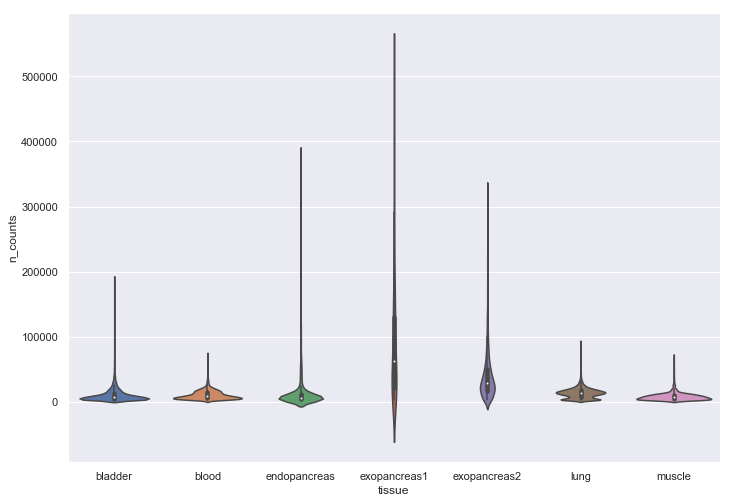

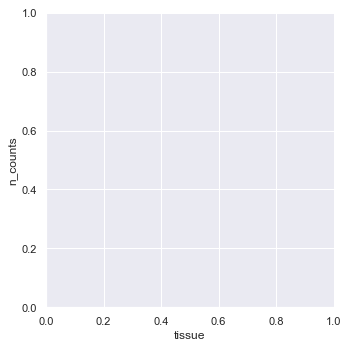

In [46]:
# df = adata
fig, ax = plt.subplots();
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.catplot(data=adata.obs,y='n_counts',x='tissue',kind='violin',ax=ax)
   
sns.despine()

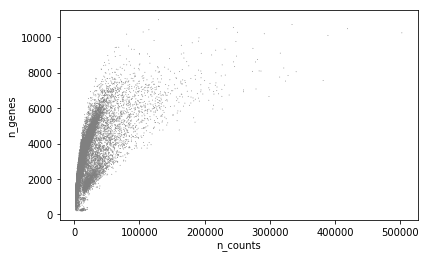

In [29]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Because we're doing first exploratory pass let's remove cells that have more than 5000 genes given that those have higher chances of being doublets

In [ ]:
adata = adata[adata.obs['n_genes'] < 5000, :]

In [4]:
adata

AnnData object with n_obs × n_vars = 64367 × 21380 
    obs: '10X_plate', 'batch', 'tissue', 'method', 'sex', 'subjectid', 'n_genes'
    var: 'n_cells'

Following the standard pipeline, next we normalize, log, compute highly variable genes and scale

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [ ]:
sc.pp.log1p(adata)


In [ ]:
adata.raw = adata

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(adata)


In [75]:
adata


AnnData object with n_obs × n_vars = 54702 × 26577 
    obs: 'batch', 'replicate', 'tissue', 'method', 'sex', 'subjectid'

In [ ]:
sc.pp.scale(adata, max_value=10)


Next we compute PCA

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')


In [ ]:
sc.pl.pca(adata, color='tissue')


In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)


Now we're ready to start fishing out some structure in the data

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=24)


In [ ]:
sc.tl.umap(adata)


In [ ]:
# sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['tissue'])

In [ ]:
set(adata.obs['tissue'])

In [ ]:
sc.pl.umap(adata, color=['tissue'],use_raw=False)

Let's take a look at one tissue as e.g. for batch effect...

In [ ]:
sc.pl.umap(adata[adata.obs['tissue']=='bladder'], color=['10X_plate'])

Looking good! Into clustering...

In [ ]:
sc.tl.louvain(adata)

In [ ]:
sc.pl.umap(adata, color=['tissue','10X_plate','louvain'])

Using the wilcoxon rank test we can compute the marker genes for each of the 45 global clusters

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sapiens_rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
sapiens_rank_genes.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-global-rank-genes.csv')
sapiens_rank_genes.head(15)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
sapiens_rank_genes_scores = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores','pvals']})
sapiens_rank_genes_scores.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-global-rank-genes-scores.csv')
sapiens_rank_genes_scores.head(25)

Let's look at the overall cycling distribution just for curiosity

In [ ]:
# cell cycle distribution -- using Tirosh et al',' Science 2015
g1s_genes =  ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
         'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
         'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']

g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2',
        'CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C',
        'RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3',
        'CBX5','CENPA']


In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=g1s_genes, g2m_genes=g2m_genes)


In [ ]:
adata

In [ ]:
sc.pl.umap(adata,color=['tissue','phase'])

Next we will look at the overall tissue compartments

In [ ]:
# add tissue compartments -- to be added
epithelial_markers = []
stromal_markers = []
immune_markers = []
endothelial_markera = []

# Split the tissues

In [ ]:
adata.obs.groupby(['tissue','10X_plate'])['subjectid'].agg({'ncells pilot':len})#.to_csv('/maca-bulk/sapiens/ncell_pilot.csv')




In [ ]:
adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered.h5ad')
print('tissue','total number of cells')
for t in list(set(adata.obs['tissue'])):
    tiss = adata[adata.obs['tissue']==t]
    print(t,len(tiss))
    tiss.write('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'.h5ad')
    

Analyse each tissue individually

In [ ]:
adata_all_tissues = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered.h5ad')
for t in list(set(adata_all_tissues.obs['tissue'])):
    print(' ')
    print(' ')
    print(' ')
    print(' ')
    print(' ')
    print('Now looking at ' +t+ '!!!')
    print(' ')
    adata = read_h5ad('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'.h5ad')
    
    print('make sure data is consistent...')
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    print('get global view of the tissue')
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
    
    print('repeat the basic pre-processing')
    adata = adata[adata.obs['n_genes'] < 5000, :]
    adata = adata[adata.obs['n_counts'] > 500, :]
    
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pp.scale(adata, max_value=10)
    
    print('PCA')
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_overview(adata)
    
    print('neighbors')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
    
    print('visualizations')
    sc.tl.umap(adata)
    sc.tl.tsne(adata)
    
    print('doing Louvain clustering for quick overview but likely to change this into Leiden')
    sc.tl.louvain(adata,resolution=.5)
    
    print('plot')
    sc.pl.tsne(adata, color=['10X_plate','louvain'],cmap='Oranges',ncols=1)
    sc.pl.umap(adata, color=['10X_plate','louvain'],cmap='Oranges',ncols=1)
    
    print('compute tissue rank genes')
    sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
    tiss_rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
    tiss_rank_genes.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'-rank-genes.csv')
    
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    tiss_rank_genes_score = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names', 'scores','pvals']})
    tiss_rank_genes_score.to_csv('/maca-bulk/sapiens/tabula-sapiens-10X-pilot-filtered-'+t+'-rank-genes-score.csv')
    print(tiss_rank_genes.head(10))



    